# DH

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
from sympy import symbols, sin, cos, simplify, trigsimp, pi
from math import radians as d2r
from math import degrees as r2d
from math import atan2, sqrt, acos, fabs

In [18]:
class mDH(object):
    """
    This uses the modified DH parameters
    see Craig, eqn (3.6)
    """
    def __init__(self, params):
        t = np.eye(4)
        for p in params:
            t = t.dot(self.makeT(*p))
        self.dh = t
        self.eval()
    
    def getPosition(self):
        return [float(x) for x in dh[0:3, 3]]
    
    def printT(self):
        """Print out the entire T matrix"""
        R = self.dh[0:3,0:3]
        D = self.dh[0:3, 3]
        print('-'*30)
        print('Position:')
        print('  x:', D[0])
        print('  y:', D[1])
        print('  z:', D[2])
        # R(n, o, a)
        print('-'*30)
        print('Orientation')
        print('  nx:', R[0,0])
        print('  ny:', R[0,1])
        print('  nz:', R[0,2])
        print('')
        print('  ox:', R[1,0])
        print('  oy:', R[1,1])
        print('  oz:', R[1,2])
        print('')
        print('  ax:', R[2,0])
        print('  ay:', R[2,1])
        print('  az:', R[2,2]) 

    def makeT(self, a, alpha, d, theta):
        return np.array([
            [           cos(theta),           -sin(theta),           0,             a],
            [sin(theta)*cos(alpha), cos(theta)*cos(alpha), -sin(alpha), -d*sin(alpha)],
            [sin(theta)*sin(alpha), cos(theta)*sin(alpha),  cos(alpha),  d*cos(alpha)],
            [                    0,                     0,           0,             1]
        ])
    
    def eval(self):
        """
        This allows you to simplify the trigonomic mess that kinematics can
        create and also substitute in some inputs in the process
        """
        c = []
        for row in self.dh:
            r = []
            for col in row:
                # use python symbolic toolbox to simplify the trig mess above 
                r.append(simplify(col))
            c.append(r)
        self.dh = np.array(c)

In [66]:
def cosine_law(a, b, c, phase=False):
    if phase:
        angle = ((c**2 - (a**2 + b**2))/(2*a*b))
    else:
        angle = ((c**2 - (a**2 + b**2))/(-2*a*b))
    
#     print('cosine_law', angle)
        
    if angle > 1 or angle < -1:
        raise Exception('angle outside range')
    return acos(angle)


def line(x1, y1, x2, y2):
    return sqrt((x2-x1)**2 + (y2-y1)**2)


def mag(a, b):
    return sqrt(a**2 + b**2)

def mag3(a, b, c):
    return sqrt(a**2 + b**2 + c**2)

class AL5D(mDH):
    l1 = 5.75
    l2 = 7.375
    l3 = 3.375
    
    def __init__(self):
        t1, t2, t3, t4 = symbols('t1 t2 t3 t4')

        a2 = 0.0
        a3 = self.l1   # shoulder to elbow
        a4 = self.l2  # elbow to wrist
        a5 = self.l3  # wrist to end effector

        params = [
            [ 0,    0, a2, t1],
            [ 0, pi/2,  0, t2],
            [a3,    0,  0, t3],
            [a4,    0,  0, t4],
            [a5,    0,  0,  0]
        ]
        
        mDH.__init__(self, params)
        
    def subs(self, angles):
        """
        This allows you to simplify the trigonomic mess that kinematics can
        create and also substitute in some inputs in the process
        """
        m = [(t1,angles[0]), (t2,angles[1]), (t3, angles[2]), (t4, angles[3])]
        c = []
        for row in self.dh:
            r = []
            for col in row:
                r.append(col.subs(m))
            c.append(r)
        return np.array(c)
    
    def inverse(self, x, y, z, orient):
        """
        Azimuth angle is between x and w and lies in the x-y plane

                   ^ x
             w     |
               \   |
                \  |
                 \ |
                  \|
        <----------+ (z is out of the page - right hand rule)
        y

        Most of the robot arm move in the plane defined by w-z

        ^ z
        |   o-----o
        |  /       \
        | /         E
        |/
        +----------------> w

        All joint angles returned are in radians: (t1, t2, t3, t4)

        """
        l1 = self.l1
        l2 = self.l2
        l3 = self.l3

        # check workspace constraints
        if z < 0:
            raise Exception('z in ground')
        elif mag3(x,y,z) > (l1 + l2 + l3):
            raise Exception('out of reach')

        # get x-y plane azimuth
        t1 = atan2(y, x)

        # Now, most of the arm operates in the w-z frame
        w = mag(x, y)         # new frame axis
        gamma = atan2(z, w)
        r = mag(z, w)

        c = mag(w-l3*cos(orient), z-l3*sin(orient))

        t3 = cosine_law(l1, l2, c, True)

        d = cosine_law(l2, c, l1)
        e = cosine_law(c, l3, r)
        t4 = pi - d - e

        alpha = cosine_law(l1, c, l2)
        beta = cosine_law(c,r,l3)

        t2 = alpha + beta + gamma

        return (t1, t2, t3, t4)

In [57]:
def rplot(t1, t2, t3, t4):
    """Given the 4 joint angles (in rads), plot the arm in the x-y and w-z planes"""
    l1 = 5.75
    l2 = 7.375
    l3 = 3.375
    ptsx = [0]
    ptsy = [0]

    # link 1
    x1 = l1*cos(t2)
    y1 = l1*sin(t2)
    ptsx.append(x1)
    ptsy.append(y1)

    # link 2
    x2 = x1 + l2*cos(t2 + t3)
    y2 = y1 + l2*sin(t2 + t3)
    ptsx.append(x2)
    ptsy.append(y2)

    # link 3
    x3 = x2 + l3*cos(t2 + t3 + t4)
    y3 = y2 + l3*sin(t2 + t3 + t4)
    ptsx.append(x3)
    ptsy.append(y3)

    plt.subplot(1,2,1,projection='polar')
    plt.plot([0, t1], [0, 1.0])
    plt.grid(True)
    plt.title('Azimuth Angle (x-y plane)')

    plt.subplot(1,2,2)
    plt.plot(ptsx, ptsy, 'b-', marker='o')
    plt.axis('equal')
    plt.grid(True)
    plt.title('w-z Plane')

In [53]:
al5d = AL5D()

In [54]:
angles = [0, pi/2, -pi/2, 0]
t = al5d.subs(angles)

In [55]:
print(t)

[[1.00000000000000 0 0 10.7500000000000]
 [0 0 -1.00000000000000 0]
 [0 1.00000000000000 0 5.75000000000000]
 [0 0 0 1.00000000000000]]


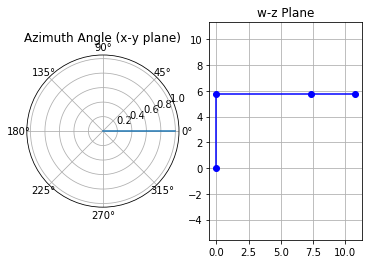

In [56]:
rplot(*angles)

In [77]:
import serial

class Arm(object):
    pwm = (1,2,3)
    
    def __init__(self, arm, port):
        self.arm = arm
#         self.ser = serial.Serial(port, 9600, timeout=0.1)
        
    def __del__(self):
#         self.ser.close()
        pass

    def command(self, angle):
        return '{:6.3f}'.format(angle)
        
    def move(self, x, y, z, o):
        angles = self.arm.inverse(x,y,z,o)
        angles = [float(x) for x in angles]
        
        cmd = []
        for a in angles:
            c = self.command(a)
            cmd.append(c)
        cmd.append(' t??\n\r')
#         self.write(''.join(cmd))
        print(''.join(cmd))

In [78]:
arm = Arm(al5d, port='/dev/null')

pts = [
    (5,5,5, -pi/2),
    (6,6,6, 0)
]

for p in pts:
    arm.move(*p)

 0.785 1.539 1.175 1.935 t??

 0.785 1.969 1.874 0.095 t??

